In [1]:
import anndata
import pandas as pd
from GenePanelDesign.api.design import GenePanelDesigner, GenePanelSummerizer
import numpy as np

# load data

In [2]:
NN_celltypes = ['Microglia NN','OPC NN','Oligo NN','Astro NN']

In [3]:
design_df = pd.read_csv('../221027_AMB_metadata.csv',index_col=0)
design_df = design_df[['Age','MajorType']]
design_df = design_df[~design_df['MajorType'].isin(NN_celltypes)]
design_df.head(5)

,Age,MajorType
cell,,
14C_M_2242,8wk,PAG/PCG
AMB_200604_18mo_3F_4E_2_P5-2-N5-N3,18mo,MSN D1 Gaba
9H_M_708,8wk,CA3 Glut
AMB_200611_18mo_7H_8H_9G_2_P8-1-G20-O2,18mo,COA Glut
AMB_200317_9mo_11E_11F_12E_1_P1-1-E6-K13,9mo,CA3 Glut


In [4]:
gene_meta = pd.read_csv("../GeneMetadata.csv.gz", index_col='gene_name')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_meta = gene_meta[gene_meta['length'] > 1000]

#gene_id_to_name = gene_meta["gene_name"].to_dict()
gene_name_to_id = gene_meta["geneslop2k"].to_dict()

In [5]:
adata = anndata.read_h5ad('../230424_panel_design_v2/adata/All_Genes.mCH.h5ad')
adata = adata[design_df.index, gene_meta['geneslop2k']]
adata

View of AnnData object with n_obs × n_vars = 120697 × 29432
    var: 'chrom', 'end', 'start'

And a design table with the aspects (col) of interest in the gene panel design.

# panel design

## initialize the gene panel designer

initialize the designer with a cell by gene matrix  and a design table (meta table). If it is a count matrix (```is_count_matrix```), the matrix wiil be normalized to ```log(1+CPM)``` first, and then selected top 10,000 highly varialbe genes.

Users could do their own normalization and feature selection, and provide the result adata as the input. ```log(1+CPM)``` normalization is prefered, though this algrithm may also work for other kinds (not tested yet).

In [6]:
designer = GenePanelDesigner(adata, design_df, 
                             downsample_per_group = 500,
                             downsample_max = 20000,
                             is_count_matrix=False,
                             n_jobs = 1)

processing the data ...
Done.
Initialize gene selectors ... Done.


In [7]:
designer

## design panel for each aspect

The ```make_panels``` method makes a single panel for each aspect (col) in the design table

The algorithm will need some seed genes to start the panel construction.

These seed genes can be provided by users with the parameter of ```genes_to_include``` if there are any pre-selected genes of interests. 

Alternatively, the algorithm will automatically initialize with some genes as seeds with the parameter of ```init_panel_with```. Currently, there are two methods for such initialization: 1) one-vs-rest marker calling (```ovr```) and 2) genes with top mutual information (```mi```) against categorical information in the design table.

In [8]:
genes_names_to_include = ["Slc17a6","Slc17a7","Gad1","Gad2","Prex1","Cux2",
                  "Rorb","Ptgfrn","Xkr7","Tcerg1l","Tle4","Tshz2",
                  "Galnt10","Rerg","Fibcd1","Dock10","Lhx6","Lamp5",
                  "Vip","Sst","Pvalb","Foxp2","Drd1","Drd2","Mobp",
                  "Pdgfra","Csf1r","Cspg4","Olig2","Olig1","Rorb","Slc1a2","Aqp4","Ctss",]

genes_to_include = [gene_name_to_id[gene_name] for gene_name in genes_names_to_include]

In [9]:
shared_genes = list(set(adata.var_names) & set(genes_to_include))
genes_to_include = shared_genes

In [10]:
#genes_to_include = []

Users can specify the minimun and maximun numbers of genes for each aspect. 

Please note that these numbers will not be met exactly. 
For example, a single panel may end with 103 genes when 100 was specified as maximun gene number.

In [11]:
min_genes = {'Age':20,
             'MajorType':250}
max_genes = min_genes

Users can specify the order of design of single panels. 
The late panel will be constructed with the genes from early panels as seed genes. 
The panels with the same order will be constructed independently.

For example, in the following case, the single panels for ```'MethylCellType'``` and ```RnaCellType``` will be firstly constructed independently. The panels for ```'L23IT-Region'``` and ```'MSN-D1-Region'``` will be constrcuted separately with the input of the results of ```'MethylCellType'``` and ```RnaCellType```.

In [12]:
order = {'MajorType':1, 
         'Age':2,
         }

The algorithm tries to maximize the pairwise distances between the categories of the aspect to certain extent.
This extent is specified by a soft parameter ```dist_ratio```. 

For example, when setting ```dist_ratio=0.2```, 
the algorithm will try to make the category pairwise distance with the selected genes 
to 20% of the distance with the full gene list.

In practice, set ```dist_ratio=0.1``` or ```=0.2``` will be sufficent, 
and usually ends up with more than 0.5 with the final gene panel 

In [13]:
panels = designer.make_panels(order=order, genes_to_include=genes_to_include, 
                              min_genes=min_genes, 
                              max_genes=max_genes,
                              dist_ratio=0.2,
                              fdr=0.05,
                              init_panel_with='ovr', 
                              rank_genes_with='welch-t')


Genes will be selected in the order of 

V
|
|
+------ user-specified: 33
|
|
+------ MajorType : 250
|
|
+------ Age : 20
|
|
V

Analyzing...


For the condition MajorType: 100%|██████████| 1.0/1.0 [00:02<00:00,  2.37s/it]                 
For the condition Age: 100%|██████████| 1.0/1.0 [00:00<00:00,  2.29it/s]               


## combine panels for the final design

```finalize_panels``` combines signle gene panels to a final panel. 
This usually involves remove genes if the total gene number from each aspect is larger than demanded.

Users could specified the impoartance of each aspect with the parameter ```weights```.

In [14]:
weights = {'MajorType':1, 
           'Age':0.5,
           }

In [15]:
final_panel = designer.finalize_panels(panels, final_genes=500, weights=weights)

# check design

the final panel

In [16]:
final_panel.to_csv('final_panel.csv', index = True)

In [17]:
final_panel.index.name = 'gene'

In [18]:
final_panel.sample(5)

,Name,Reason,PrevCount,welch-t,p-val,adj_p-val,diff,fc,significant,fg,bg,score
gene,,,,,,,,,,,,
ENSMUSG00000010476.14,MajorType,< dist-cutoff,149,10.473272,1.895903e-24,7.750029e-22,0.586352,0.756854,True,PAG/PCG,AMY Gaba,10.473272
ENSMUSG00000038860.15,MajorType,< dist-cutoff,208,15.380938,9.655996e-47,2.899952e-44,0.824641,0.483019,True,OLF-ENT Glut,L2/3 IT ENT Glut,15.380938
ENSMUSG00000041119.12,MajorType,< dist-cutoff,81,26.458409,7.213781e-98,1.179533e-94,1.027026,0.456740,True,IT EP-CLA Glut,L6 IT CTX Glut,26.458409
ENSMUSG00000038593.18,Age,< dist-cutoff,271,3.650148,1.320925e-04,3.351507e-02,0.056516,0.939444,True,18mo,9mo,3.650148
ENSMUSG00000035168.16,MajorType,< dist-cutoff,218,8.268353,2.814205e-16,6.845262e-14,0.311941,0.851640,True,PAG/PCG,Scdg Glut,8.268353


In [24]:
final_panel['Name'].value_counts()

MajorType      222
Age             28
_Predefine_      1
Name: Name, dtype: int64

## overview of the panel

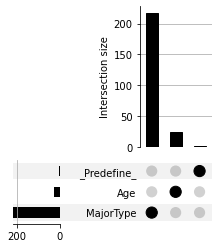

In [19]:
gxc = GenePanelSummerizer.summarize_gene_by_condition(final_panel)

## how each gene separate categories

pairwise distance for 


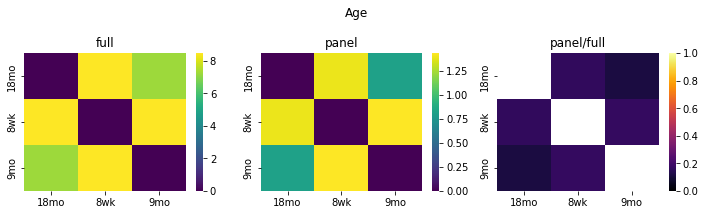

pairwise distance for 


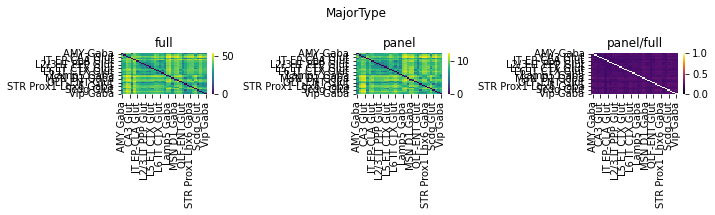

In [21]:
for aspect in designer.names:
    print('pairwise distance for ')
    GenePanelSummerizer.summarize_dist_matrix(designer.selectors[aspect], final_panel.index)    


## how the gene panel separate categories in clustering

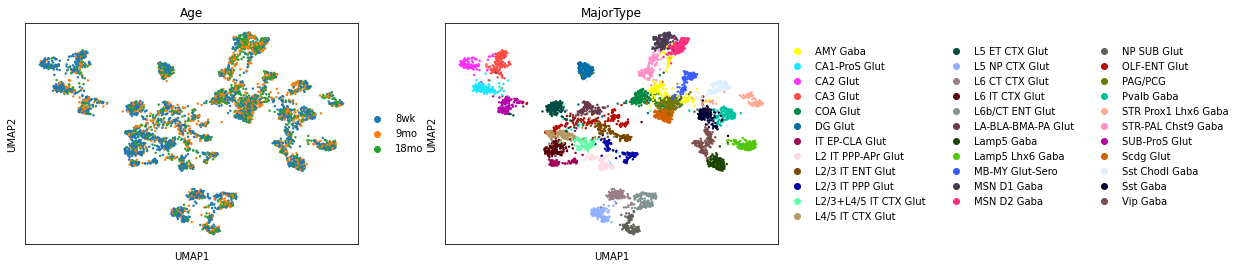

In [22]:
GenePanelSummerizer.check_clusters(designer.adata,  design_df, final_panel)
pass